In [2]:
# import numpy as np
# import tensorflow as tf
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# import seaborn as sns
# import pandas as pd
# import os
# import glob
# from collections import Counter
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
# from tensorflow.keras import Model, layers
# from tensorflow.keras.utils import to_categorical

# # Path to dataset
# DATASET_PATH = '/kaggle/input/rose-dataset/Final DataSet'

# # Step 1: Load image paths and labels
# classes = sorted(os.listdir(DATASET_PATH))  # Auto-detect class folders

# image_paths = []
# image_labels = []

# for idx, class_name in enumerate(classes):
#     class_folder = os.path.join(DATASET_PATH, class_name)
#     files = glob.glob(os.path.join(class_folder, '*'))
#     image_paths.extend(files)
#     image_labels.extend([idx] * len(files))

# image_paths = np.array(image_paths)
# image_labels = np.array(image_labels)

# # ✅ Step 1.5: Show number of images per class
# label_counts = Counter(image_labels)
# print("Number of images per class:")
# for idx in sorted(label_counts):
#     print(f"{classes[idx]}: {label_counts[idx]} images")

# plt.figure(figsize=(10, 6))
# plt.bar([classes[i] for i in label_counts.keys()], label_counts.values(), color='teal')
# plt.title("Number of Images per Class")
# plt.xlabel("Class")
# plt.ylabel("Image Count")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # Step 2: Split dataset
# train_paths, test_paths, train_labels, test_labels = train_test_split(
#     image_paths, image_labels, test_size=0.15, stratify=image_labels, random_state=42)

# train_paths, val_paths, train_labels, val_labels = train_test_split(
#     train_paths, train_labels, test_size=0.15, stratify=train_labels, random_state=42)

# # Step 3: Data generators
# IMG_SIZE = (224, 224)
# BATCH_SIZE = 32

# def path_label_generator(paths, labels, batch_size=BATCH_SIZE, shuffle=True, augment=False):
#     datagen = ImageDataGenerator(
#         preprocessing_function=preprocess_input,
#         shear_range=0.1 if augment else 0,
#         zoom_range=0.2 if augment else 0,
#         horizontal_flip=augment)

#     while True:
#         if shuffle:
#             indices = np.random.permutation(len(paths))
#         else:
#             indices = np.arange(len(paths))
#         for start in range(0, len(paths), batch_size):
#             end = start + batch_size
#             batch_idx = indices[start:end]
#             batch_images = []
#             batch_labels = []
#             for i in batch_idx:
#                 img = tf.keras.preprocessing.image.load_img(paths[i], target_size=IMG_SIZE)
#                 img = tf.keras.preprocessing.image.img_to_array(img)
#                 batch_images.append(img)
#                 batch_labels.append(labels[i])
#             batch_images = np.array(batch_images)
#             batch_labels = to_categorical(batch_labels, num_classes=len(classes))
#             batch_images = datagen.standardize(batch_images)
#             yield batch_images, batch_labels

# # Step 4: Prepare generators
# train_generator = path_label_generator(train_paths, train_labels, augment=True)
# val_generator = path_label_generator(val_paths, val_labels, shuffle=False, augment=False)
# test_generator = path_label_generator(test_paths, test_labels, shuffle=False, augment=False)

# train_steps = len(train_paths) // BATCH_SIZE
# val_steps = len(val_paths) // BATCH_SIZE
# test_steps = len(test_paths) // BATCH_SIZE

# # Step 5: Build model
# conv_base = ResNet50(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3))
# for layer in conv_base.layers:
#     layer.trainable = False

# x = conv_base.output
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(128, activation='relu')(x)
# predictions = layers.Dense(len(classes), activation='softmax')(x)
# model = Model(inputs=conv_base.input, outputs=predictions)

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Step 6: Train model
# EPOCHS = 10
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_steps,
#     validation_data=val_generator,
#     validation_steps=val_steps,
#     epochs=EPOCHS
# )

# # Step 7: Evaluate model
# loss, accuracy = model.evaluate(test_generator, steps=test_steps)
# print(f"Test Loss: {loss:.4f}")
# print(f"Test Accuracy: {accuracy:.4f}")

# # Step 8: Predict
# predictions, true_labels = [], []
# for _ in range(test_steps):
#     x_batch, y_batch = next(test_generator)
#     preds = model.predict(x_batch)
#     predictions.append(preds)
#     true_labels.append(y_batch)

# predictions = np.vstack(predictions)
# true_labels = np.vstack(true_labels)
# predicted_classes = np.argmax(predictions, axis=1)
# true_classes = np.argmax(true_labels, axis=1)

# # Step 9: Report and Confusion Matrix
# report = classification_report(true_classes, predicted_classes, target_names=classes, labels=list(range(len(classes))))
# print(report)

# cm = confusion_matrix(true_classes, predicted_classes, labels=list(range(len(classes))))
# df_cm = pd.DataFrame(cm, index=classes, columns=classes)
# plt.figure(figsize=(8,6))
# sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix')
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()

# # Step 10: Accuracy and Loss Curves
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# plt.figure(figsize=(12,5))
# plt.subplot(1, 2, 1)
# plt.plot(range(EPOCHS), acc, label='Training Accuracy')
# plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(range(EPOCHS), loss, label='Training Loss')
# plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

# # Step 11: ROC Curve
# plt.figure(figsize=(10, 8))
# for i in range(len(classes)):
#     fpr, tpr, _ = roc_curve(true_labels[:, i], predictions[:, i])
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

# plt.plot([0, 1], [0, 1], 'k--')
# plt.title('ROC Curve per Class')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.legend(loc='lower right')
# plt.show()


**ResNet-50**

**DesNet**

2025-09-12 15:30:56.453600: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757691056.622100      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757691056.670920      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of images per class:
Chickenpox: 1000 images
Cowpox: 1000 images
HFMD: 1000 images
Healthy: 1000 images
Measles: 1000 images
Monkeypox: 1000 images


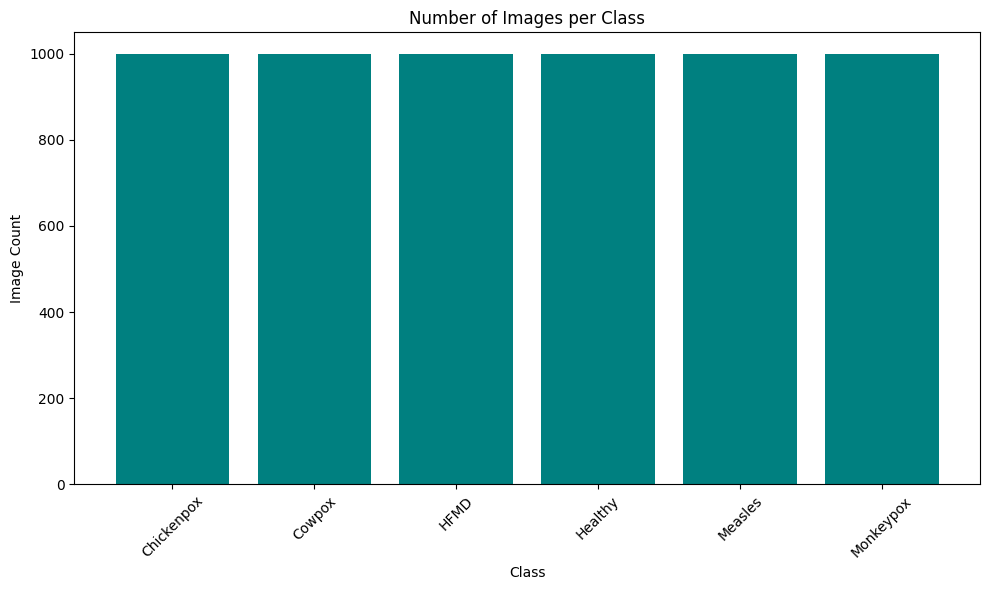

I0000 00:00:1757691070.639495      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


I0000 00:00:1757691107.634096      93 service.cc:148] XLA service 0x7efe4c003620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757691107.634918      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757691112.093701      93 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/135 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.2500 - loss: 1.9263   

I0000 00:00:1757691130.590491      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


135/135 ━━━━━━━━━━━━━━━━━━━━ 124s 526ms/step - accuracy: 0.6121 - loss: 1.0571 - val_accuracy: 0.9334 - val_loss: 0.2297
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 33s 92ms/step - accuracy: 0.9124 - loss: 0.2737 - val_accuracy: 0.9796 - val_loss: 0.1145
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.9582 - loss: 0.1472 - val_accuracy: 0.9851 - val_loss: 0.0779
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 30s 226ms/step - accuracy: 0.9710 - loss: 0.1106 - val_accuracy: 0.9945 - val_loss: 0.0419
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.9848 - loss: 0.0687 - val_accuracy: 0.9946 - val_loss: 0.0300
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.9861 - loss: 0.0568 - val_accuracy: 0.9959 - val_loss: 0.0237
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.9904 - loss: 0.0385 - val_accuracy: 0.9973 - val_loss: 0.0145
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.9935 - loss: 0.0324 - val_accu

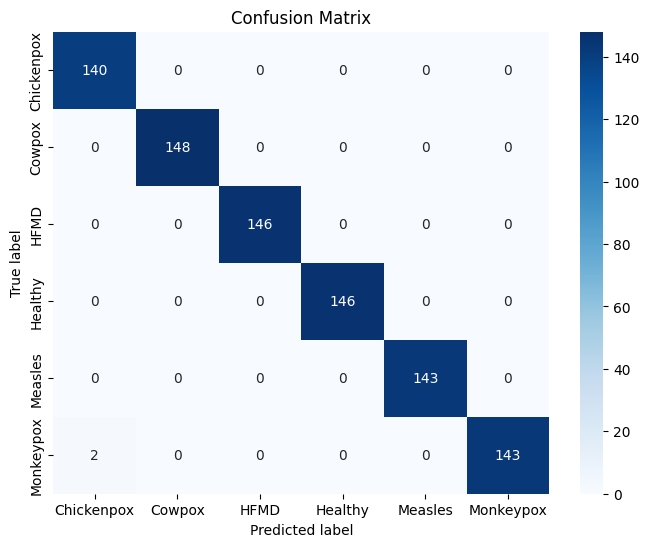

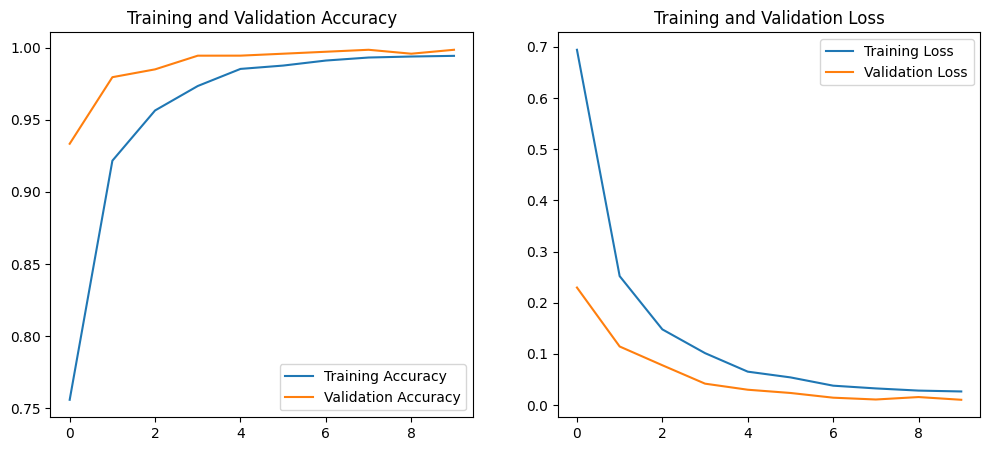

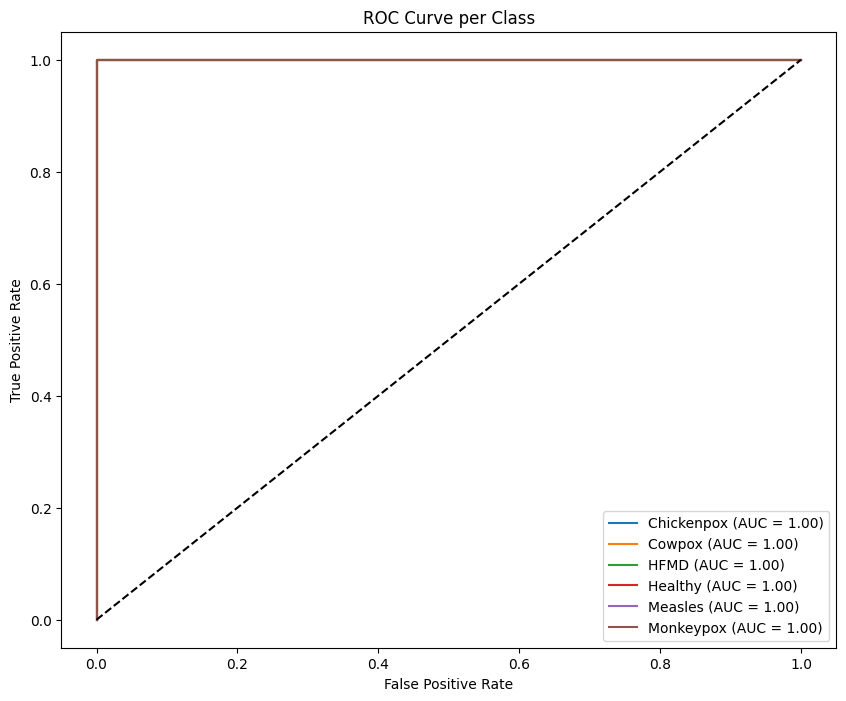

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import pandas as pd
import os
import glob
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
from tensorflow.keras import Model, layers
from tensorflow.keras.utils import to_categorical

# Path to dataset
DATASET_PATH = '/kaggle/input/monkeypox/Augmentation dataset'

# Step 1: Load image paths and labels
classes = sorted(os.listdir(DATASET_PATH))  # Auto-detect class folders

image_paths = []
image_labels = []

for idx, class_name in enumerate(classes):
    class_folder = os.path.join(DATASET_PATH, class_name)
    files = glob.glob(os.path.join(class_folder, '*'))
    image_paths.extend(files)
    image_labels.extend([idx] * len(files))

image_paths = np.array(image_paths)
image_labels = np.array(image_labels)

# ✅ Step 1.5: Show number of images per class
label_counts = Counter(image_labels)
print("Number of images per class:")
for idx in sorted(label_counts):
    print(f"{classes[idx]}: {label_counts[idx]} images")

plt.figure(figsize=(10, 6))
plt.bar([classes[i] for i in label_counts.keys()], label_counts.values(), color='teal')
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 2: Split dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, image_labels, test_size=0.15, stratify=image_labels, random_state=42)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.15, stratify=train_labels, random_state=42)

# Step 3: Data generators
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def path_label_generator(paths, labels, batch_size=BATCH_SIZE, shuffle=True, augment=False):
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.1 if augment else 0,
        zoom_range=0.2 if augment else 0,
        horizontal_flip=augment)

    while True:
        if shuffle:
            indices = np.random.permutation(len(paths))
        else:
            indices = np.arange(len(paths))
        for start in range(0, len(paths), batch_size):
            end = start + batch_size
            batch_idx = indices[start:end]
            batch_images = []
            batch_labels = []
            for i in batch_idx:
                img = tf.keras.preprocessing.image.load_img(paths[i], target_size=IMG_SIZE)
                img = tf.keras.preprocessing.image.img_to_array(img)
                batch_images.append(img)
                batch_labels.append(labels[i])
            batch_images = np.array(batch_images)
            batch_labels = to_categorical(batch_labels, num_classes=len(classes))
            batch_images = datagen.standardize(batch_images)
            yield batch_images, batch_labels

# Step 4: Prepare generators
train_generator = path_label_generator(train_paths, train_labels, augment=True)
val_generator = path_label_generator(val_paths, val_labels, shuffle=False, augment=False)
test_generator = path_label_generator(test_paths, test_labels, shuffle=False, augment=False)

train_steps = len(train_paths) // BATCH_SIZE
val_steps = len(val_paths) // BATCH_SIZE
test_steps = len(test_paths) // BATCH_SIZE

# ✅ Step 5: Build model using DenseNet201
conv_base = DenseNet201(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3))
for layer in conv_base.layers:
    layer.trainable = False

x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(len(classes), activation='softmax')(x)
model = Model(inputs=conv_base.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train model
EPOCHS = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=EPOCHS
)

# Step 7: Evaluate model
loss, accuracy = model.evaluate(test_generator, steps=test_steps)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Step 8: Predict
predictions, true_labels = [], []
for _ in range(test_steps):
    x_batch, y_batch = next(test_generator)
    preds = model.predict(x_batch)
    predictions.append(preds)
    true_labels.append(y_batch)

predictions = np.vstack(predictions)
true_labels = np.vstack(true_labels)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(true_labels, axis=1)

# Step 9: Report and Confusion Matrix
report = classification_report(true_classes, predicted_classes, target_names=classes, labels=list(range(len(classes))))
print(report)

cm = confusion_matrix(true_classes, predicted_classes, labels=list(range(len(classes))))
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(8,6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Step 10: Accuracy and Loss Curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Step 11: ROC Curve
plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve per Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
